In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import cmath
import scipy
from scipy import interpolate
from scipy import integrate
#np.set_printoptions(threshold=sys.maxsize)
N = 10000 # number of iterator steps
H_to_K = 1/0.000003166808534191
dr = 0.00102
def percent_diff(x1,x2):
    C = (abs(x2-x1)/((x1+x2)/2))*100
    return C

# $V(r) = \frac{C_{12}}{r^{12}} - \frac{C_{6}}{r^{6}}$
## $C_{12} = 3.05\times10^{8} E_{h}a_{0}, C_{6} = 4710 E_{h}a_{0}$
## $r_{1} + N \cdot dr = r_{2}$

C:\Users\nienn\AppData\Local\Temp\ipykernel_38356\1690743265.py:17: RuntimeWarning: invalid value encountered in sqrt
  k = np.sqrt(2*mu*(Eo - Vr))


 min of Vr = -5741.95293656363K
 r1max = 6.33694314956665ao
-5741.95293656363
 The ratio Eo/V(r) at r = 60ao is equal to -3.1369601707185214e-05


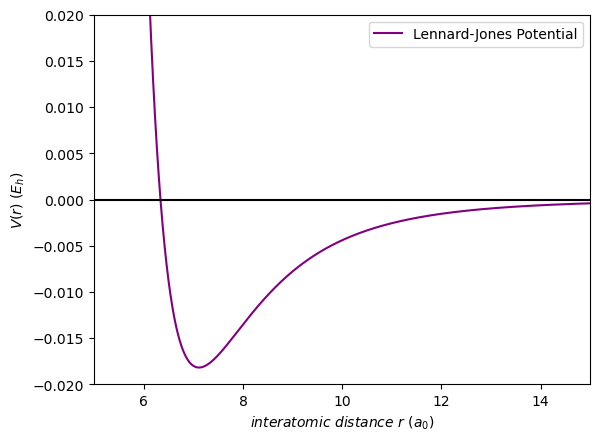

In [3]:
tol = 1e-4
#r1 = np.linspace(1e-2, 6, 500) #rmin in ao
r = np.linspace(4.5,60, N) # range of r values to iterate over, ~0 -> 80 Bohr radii
#psi = np.zeros(N)  # Initializing psi(r) as array of zeros

C12I = 3.05e8 #C12 coefficient in Eh*ao
C6I = 4710 #C6 coefficient in Eh*ao
Vr = (C12I*(1/(r**12))) - (C6I*(1/(r**6)))
Eo = 3.166808534191e-12 # inital particle energy, 1uK in Hartrees
me = 9.1093837e-28 # electron mass in grams
mrb_g = 1.4192261e-22 # rubidium mass in grams
mrb = mrb_g*(1/me) # rubidium mass in au
mu = (mrb**2)*(1/(2*mrb)) # reduced mass of rubidium
hbar = 1.0546e-27 # reduced Planck constant in cgs
e = 4.8032e-10 # electron charge in cgs
ao = (hbar**2)*(1/(me*e**2)) # Bohr radius in cgs
k = np.sqrt(2*mu*(Eo - Vr))

lambda_min = (2*np.pi)*(1/(np.sqrt(2*mu*(Eo - min(Vr)))))
#print(f' lambda min = {lambda_min}ao')
#print(f' dr = {lambda_min/20}ao')

drmax = lambda_min*(1/20)
#print(f' dr = {dr}')

#print(f' mu = {mu}')
plt.plot(r, Vr, label = 'Lennard-Jones Potential', color = 'purple')
plt.hlines(0,0, max(r), color = 'black')
#plt.hlines(Eo,0, max(r), color = 'green')
plt.xlabel('$ interatomic$ $distance$ $r$ $(a_{0})$')
plt.ylabel('$V(r)$ $(E_{h})$')
plt.ylim(-0.02, 0.02)
plt.xlim(5,15)
plt.legend()


print(f' min of Vr = {min(Vr)*H_to_K}K')

def bisection(f, d, b, tol=1e-6):
    """
    Find a root of f(x) in the interval a<x<b, using bisection search.

    A valid interval must have a < b, and f(a) and f(b) must have opposite signs.

    Returns: 
        A root of x0, i.e. a solution to f(x0) = 0.

    Args:
        f: function to be studied; should take one argument.
        a: lower end of search interval
        b: upper end of search interval

        tol: error tolerance for result (default: 1e-6)

     If either f(d) or f(b) is zero, then we already have a solution! """
    
    if f(d) == 0:
        return a
    if f(b) == 0:
        return b

    # Spot check for valid interval
    assert b>d
    if f(b) * 1/f(d) > 0:
        return 'invalid interval'

    while (b-d) > tol:
        c = (d+b)/2
        if f(c) * 1/f(d) < 0:
            # c and a have opposite sign: new interval is [d,c]
            b = c
        elif f(c) * 1/f(b) < 0:
            # c and b have opposite sign: new interval is [c,b]
            d = c
        else:
            # Only other possibility is that f(c) was exactly zero!
            return c
    else:
        return (d+b)*0.5  # Think: why not `return c`?
for i in range(len(Vr)):
    if Vr[i] == min(Vr):
        min_i = i
#print(f'min index = {min_i}')
#print(f'min index of V = {Vr[min_i]*H_to_K}')
def Vrr(r_range):
    LJPotential = (C12I*(1/(r_range**12))) - (C6I*(1/(r_range**6)))
    return LJPotential
r1max = bisection(Vrr,6,7)
print(f' r1max = {r1max}ao')

plt.vlines(Vr[min_i], -1, 1, color = 'black')
print(Vr[471]*H_to_K)

print(f' The ratio Eo/V(r) at r = {int(r[-1])}ao is equal to {Eo/Vr[-1]}')

## Goal: Vary C12 coefficient, observe how scattering relates

In [5]:
def wavefunction(Energy, M, rmin, rmax, h, C6, C12): # Numerov method function to find psi(r)
    global psi
    r_range = np.linspace(rmin, rmax, M)
    VLJ = (C12*(1/r_range**12)) - (C6*(1/r_range**6))
    psi[0] = 0 # impose boundary condition psi(0) = 0
    psi[1] = 1e-5 # let psi(1) = 1e-5
    ksq = 2*mu*(Energy - VLJ) # wave number squared for the energy
    
    for i in range(2,M):  # Numerov Algorithm, range is 2 -> N since psi(0), psi(1) already set
        psi[i] = ((2*(1 - (5/12)*(h**2)*ksq[i-1])*psi[i-1]) - ((1 + (1/12)*(h**2)*ksq[i-2])*psi[i-2]))*(1/(1 + (1/12)*(h**2)*ksq[i]))
    return psi*(1/max(abs(psi)))

In [6]:
Eo = 3.166808534191e-12 #initial energy in Hartrees, Eo = 1uK
r1 = 4.6 # starting iteration distance in ao
r2 = 2000 # ending iteration distance ao
numpts = int(((r2 - r1)*(1/dr)) + 1) # number of points between r1, r2 given step size dr
rr = np.linspace(r1,r2, numpts) # radial distance grid

deltas = []
#kE = []
as_C12 = []

C12_list = np.linspace(5e7, 4e8, 80) # variable range of C12 coefficients, from 2000 -> 6000 Ehao

for i in range(len(C12_list)):
    psi = np.zeros(numpts)
    Psi = wavefunction(Eo, numpts, r1, r2, dr, C6I, C12_list[i])
    Psi_prime = np.gradient(Psi, rr)
    VLJ_C = (C12_list[i]*(1/(rr**12))) - (C6I*(1/(rr**6)))
    koE = 2*mu*(Eo - VLJ_C[-1])
    #kE.append(koE)

    delta = np.arctan((np.sqrt(koE)*Psi[-1])*(1/(Psi_prime[-1]))) - np.sqrt(koE)*rr[-1]
    deltas.append(delta)
    as_C12.append(-1*delta/np.sqrt(koE))
    #print(-1*delta/np.sqrt(koE))

    if i == int(0.5*len(C12_list)):
        print('half way there!')
    if i == int(0.9*len(C12_list)):
        print('almost there!')


half way there!
almost there!


(-1000.0, 1000.0)

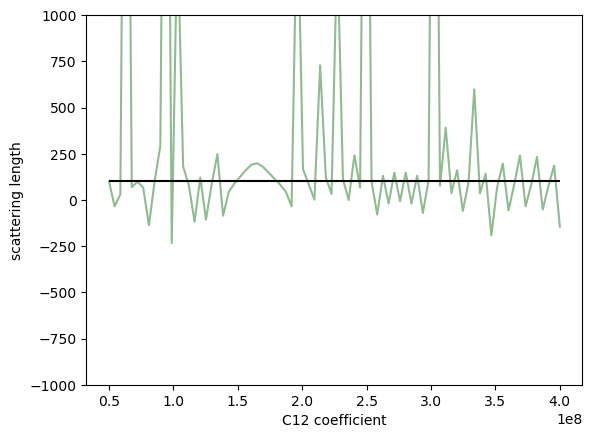

In [7]:
plt.plot(C12_list, as_C12, color = 'darkseagreen')
plt.hlines(100, min(C12_list), max(C12_list), color = 'black')
plt.xlabel('C12 coefficient')
plt.ylabel('scattering length')
plt.ylim(-1e3,1e3)

In [8]:
key_C12 = []
for i in range(len(as_C12)):
    if 99 < as_C12[i] < 101:
        print(f' with C12 = {round(C12_list[i],3)} Ehao, scattering length = {as_C12[i]}')
        key_C12.append(C12_list[i])

 with C12 = 50000000.0 Ehao, scattering length = 100.62095444823541
 with C12 = 85443037.975 Ehao, scattering length = 99.25518483190676


(-1000.0, 1000.0)

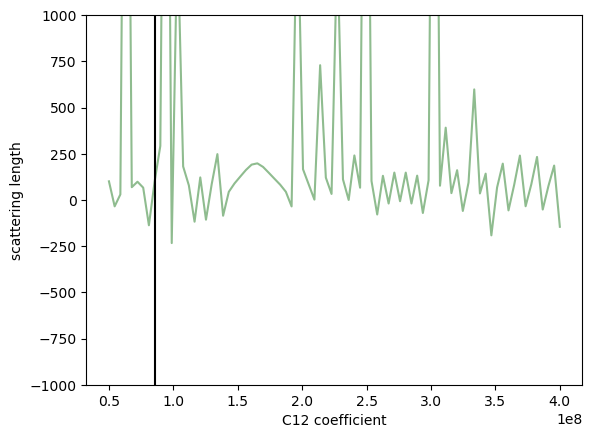

In [9]:
plt.plot(C12_list, as_C12, color = 'darkseagreen')
plt.vlines(key_C12[1], -1e3, 1e3, color = 'black')
plt.xlabel('C12 coefficient')
plt.ylabel('scattering length')
plt.ylim(-1e3,1e3)

# Infinite, negative infinite scattering length C12 finder

In [11]:
Eo = 3.166808534191e-12 #initial energy in Hartrees, Eo = 1uK
r1 = 4.6 # starting iteration distance in ao
r2 = 2000 # ending iteration distance ao
numpts = int(((r2 - r1)*(1/dr)) + 1) # number of points between r1, r2 given step size dr
rr = np.linspace(r1,r2, numpts) # radial distance grid

deltas = []
#kE = []
as_C12 = []

C12_list = np.linspace(0.901e8, 0.903e8, 100) # variable range of C12 coefficients, from 2000 -> 6000 Ehao

for i in range(len(C12_list)):
    psi = np.zeros(numpts)
    Psi = wavefunction(Eo, numpts, r1, r2, dr, C6I, C12_list[i])
    Psi_prime = np.gradient(Psi, rr)
    VLJ_C = (C12_list[i]*(1/(rr**12))) - (C6I*(1/(rr**6)))
    koE = 2*mu*(Eo - VLJ_C[-1])
    #kE.append(koE)

    delta = np.arctan((np.sqrt(koE)*Psi[-1])*(1/(Psi_prime[-1]))) - np.sqrt(koE)*rr[-1]
    deltas.append(delta)
    as_C12.append(-1*delta/np.sqrt(koE))
    #print(-1*delta/np.sqrt(koE))

    if i == int(0.5*len(C12_list)):
        print('half way there!')
    if i == int(0.9*len(C12_list)):
        print('almost there!')

half way there!
almost there!


 max scattering length = 4232.233438959766
 min scattering length = -236.04194346020014


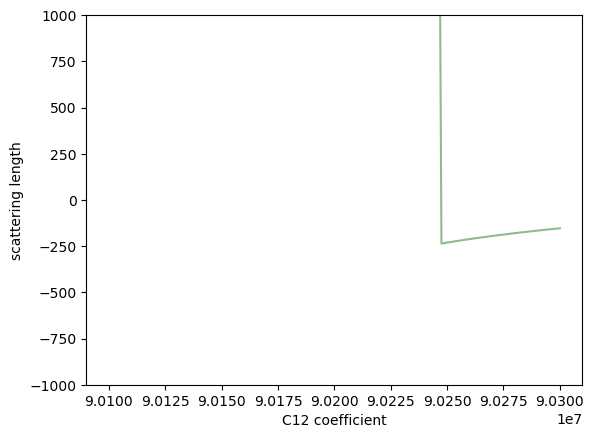

In [12]:
plt.plot(C12_list, as_C12, color = 'darkseagreen')
#plt.vlines(key_C12[1], -1e3, 1e3, color = 'black')
plt.xlabel('C12 coefficient')
plt.ylabel('scattering length')
plt.ylim(-1e3,1e3)

print(f' max scattering length = {max(as_C12)}')
print(f' min scattering length = {min(as_C12)}')

bigi = 0
smalli = 0
for i in range(len(as_C12)):
    if as_C12[i] == max(as_C12):
        bigi = i
    if as_C12[i] == min(as_C12):
        smalli = i

C12_big = C12_list[bigi]
C12_small = C12_list[smalli]




In [30]:
a1 = 4.5
b1 = 1000
dx1 = 0.05
C6 = 4610

Np1 = int((b1-a1)/dx1)
xp1 = np.linspace(a1 + dx1, b1 - dx1, Np1 - 1)

def Hamiltonian_DVR(a, b, dx, C12):
    N = int((b-a)/dx) # Number of grid points
   # print(f' N = {N}')
    x = np.linspace(a + dx,b - dx, N - 1) # grid

    #Vx = 
    #Vxmin = abs(min(VLJ))

    H_DVR = np.zeros((len(x), len(x))) # Initialize empty Hamiltonian matrix of size N x N

    for i in range(1, N):
        for j in range(1, N):
            if i == j: # fill in diagonal components of the Hamiltonian
                prefacii = (np.pi**2)/(4*mu*(b-a)**2)
                bracketii = ((2*N**2 + 1)/3) - (1/((np.sin(np.pi*(i/N)))**2))
                Vii = (C12/(x[i - 1]**12)) - (C6/(x[i - 1]**6))
                
                H_DVR[i - 1][j - 1] = prefacii*bracketii + Vii
            
            if i != j: # fill in off-diagonal components of the Hamiltonian
                prefacij = (-1**(i-j))*(np.pi**2)/(4*mu*(b-a)**2)
                bracketij = (1/((np.sin(np.pi*((i-j)/(2*N))))**2)) - (1/((np.sin(np.pi*((i+j)/(2*N))))**2))
                
                H_DVR[i - 1][j - 1] = prefacij*bracketij
                
    assert(np.allclose(H_DVR, np.transpose(H_DVR)))

    return H_DVR

Hbig = Hamiltonian_DVR(a1, b1, dx1, C12_big)
Hsmall = Hamiltonian_DVR(a1, b1, dx1, C12_small)

Eigsmall = np.linalg.eigh(Hsmall)[0]
smallbs = min(abs(Eigsmall[Eigsmall < 0]))

Eigbig = np.linalg.eigh(Hbig)[0]
bigbs = min(abs(Eigbig[Eigbig < 0]))

print(f' large neg scattering length has a smallest bound state at -{smallbs}Eh')
print(f' large pos scattering length has a smallest bound state at -{bigbs}Eh')

MemoryError: Unable to allocate 2.95 GiB for an array with shape (19909, 19909) and data type float64

# End of test for infinite/neg infinite scattering length

In [14]:
Eo = 3.166808534191e-12 #initial energy in Hartrees, Eo = 1uK
r1 = 4.6 # starting iteration distance in ao
r2 = 2000 # ending iteration distance ao
numpts = int(((r2 - r1)*(1/dr)) + 1) # number of points between r1, r2 given step size dr
rr = np.linspace(r1,r2, numpts) # radial distance grid

deltas = []
#kE = []
as_C12 = []

C12_list = np.linspace(int(key_C12[1] - 1e7), int(key_C12[1] + 1e7), 500) # variable range of C12 coefficients, from 2000 -> 6000 Ehao

for i in range(len(C12_list)):
    psi = np.zeros(numpts)
    Psi = wavefunction(Eo, numpts, r1, r2, dr, C6I, C12_list[i])
    Psi_prime = np.gradient(Psi, rr)
    VLJ_C = (C12_list[i]*(1/(rr**12))) - (C6I*(1/(rr**6)))
    koE = 2*mu*(Eo - VLJ_C[-1])
    #kE.append(koE)

    delta = np.arctan((np.sqrt(koE)*Psi[-1])*(1/(Psi_prime[-1]))) - np.sqrt(koE)*rr[-1]
    deltas.append(delta)
    as_C12.append(-1*delta/np.sqrt(koE))
    #print(-1*delta/np.sqrt(koE))

    if i == int(0.5*len(C12_list)):
        print('half way there!')
    if i == int(0.9*len(C12_list)):
        print('almost there!')


KeyboardInterrupt: 

In [ ]:
plt.scatter(C12_list, as_C12, color = 'darkseagreen')
plt.hlines(100, min(C12_list), max(C12_list), color = 'black')
plt.xlabel('C12 coefficient')
plt.ylabel('scattering length')
plt.ylim(-100,300)

In [ ]:
key_C12 = []
for i in range(len(as_C12)):
    if 99 < as_C12[i] < 101:
        print(f' with C12 = {round(C12_list[i],3)} Ehao, scattering length = {as_C12[i]}')

In [ ]:
Eo = 1e-3*3.166808534191e-12 #initial energy in Hartrees, Eo = 1nK
r1 = 4.6 # starting iteration distance in ao
r2 = 2500 # ending iteration distance ao
numpts = int(((r2 - r1)*(1/dr)) + 1) # number of points between r1, r2 given step size dr
rr = np.linspace(r1,r2, numpts) # radial distance grid

deltas = []
#kE = []
as_C12 = []

C12_list = np.linspace(5e7, 4e8, 80) # variable range of C12 coefficients, from 2000 -> 6000 Ehao

for i in range(len(C12_list)):
    psi = np.zeros(numpts)
    Psi = wavefunction(Eo, numpts, r1, r2, dr, C6I, C12_list[i])
    Psi_prime = np.gradient(Psi, rr)
    VLJ_C = (C12_list[i]*(1/(rr**12))) - (C6I*(1/(rr**6)))
    koE = 2*mu*(Eo - VLJ_C[-1])
    #kE.append(koE)

    delta = np.arctan((np.sqrt(koE)*Psi[-1])*(1/(Psi_prime[-1]))) - np.sqrt(koE)*rr[-1]
    deltas.append(delta)
    as_C12.append(-1*delta/np.sqrt(koE))
    #print(-1*delta/np.sqrt(koE))

    if i == int(0.5*len(C12_list)):
        print('half way there!')
    if i == int(0.9*len(C12_list)):
        print('almost there!')

In [ ]:
plt.scatter(C12_list, as_C12, color = 'darkseagreen')
plt.hlines(100, min(C12_list), max(C12_list), color = 'black')
plt.xlabel('C12 coefficient')
plt.ylabel('scattering length')
plt.ylim(-1e3,1e3)

In [ ]:
for i in range(len(as_C12)):
    if 99 < as_C12[i] < 101:
        print(f' with C12 = {round(C12_list[i],3)} Ehao, scattering length = {as_C12[i]}')